In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#!pip install pyspark --user
#from __future__ import print_function 
import pyspark
from pyspark.sql import functions as F
from pyspark.sql.types import *
from pyspark.mllib.stat import Statistics as stat
from pyspark.ml.feature import Bucketizer

In [3]:
#initialize spark session
spark = pyspark.sql.SparkSession.builder\
.appName("twitter") \
.getOrCreate()

sc = pyspark.SparkContext.getOrCreate()
sqlContext = pyspark.SQLContext.getOrCreate(sc)
sc.setLogLevel("ERROR")

sc.setCheckpointDir('checkpoint')

In [6]:
# load the csv dataset and create spark dataframe 
#os.chdir(path)
pdf = pd.read_csv('trumpCOVIDtweets-toxicity-tweet_ids.csv')

In [7]:
schema2 = StructType([StructField('tweet_id',LongType(), True),StructField('tweetstatus',StringType(), True),StructField('language',StringType(), True),StructField('Toxicity',FloatType(), True),StructField('Severe Toxicity',FloatType(), True),StructField('Profane',FloatType(), True),StructField('Identity Attack',FloatType(), True),StructField('Insult',FloatType(), True),StructField('Threat',FloatType(), True),StructField('Sexually Explicit',FloatType(), True),StructField('Flirtation',FloatType(), True)])
df2 = spark.createDataFrame(pdf,schema=schema2)

In [8]:
df2.toPandas().info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 298173 entries, 0 to 298172
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   tweet_id           298173 non-null  int64  
 1   tweetstatus        298173 non-null  object 
 2   language           298173 non-null  object 
 3   Toxicity           298173 non-null  float32
 4   Severe Toxicity    298173 non-null  float32
 5   Profane            298173 non-null  float32
 6   Identity Attack    298173 non-null  float32
 7   Insult             298173 non-null  float32
 8   Threat             298173 non-null  float32
 9   Sexually Explicit  298173 non-null  float32
 10  Flirtation         298173 non-null  float32
dtypes: float32(8), int64(1), object(2)
memory usage: 15.9+ MB


In [9]:
# number of language used in the dataset
df2.select("language").distinct().count()

62

In [10]:
#most used languages
df2.groupBy("language").count().orderBy(F.col("count").desc()).show()

+--------+------+
|language| count|
+--------+------+
|      en|247975|
|     und| 33335|
|      es|  2871|
|      tl|  1927|
|      in|  1074|
|      zh|  1056|
|      ht|   988|
|      et|   976|
|      ar|   946|
|      ja|   816|
|      pt|   707|
|      pa|   630|
|      fr|   559|
|      am|   550|
|      tr|   505|
|      it|   406|
|      de|   384|
|      fa|   303|
|      nl|   212|
|      sv|   204|
+--------+------+
only showing top 20 rows



In [11]:
# new dataframe with only english language tweets 
df3 = df2.filter(F.col("language")==F.lit("en"))

In [12]:
df3.summary().toPandas()

,summary,tweet_id,tweetstatus,language,Toxicity,Severe Toxicity,Profane,Identity Attack,Insult,Threat,Sexually Explicit,Flirtation
0,count,247975,247975,247975,247975,247975,247975,247975,247975,247975,247975,247975
1,mean,1.31201563537988429E18,None,None,0.34410286943456786,0.2150932678939039,0.2656051711321385,0.18432578197013252,0.3290649370491368,0.22545307738477935,0.15453934198817965,0.3437964242125894
2,stddev,2.5712288654603875E13,None,None,0.2672662624023723,0.22095899078000247,0.2516041840571657,0.16714268403642799,0.27093016156438454,0.19880431534366189,0.1759565387324263,0.11804190170099127
3,min,1311970726312849411,TWEET_BLOCKED,en,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,25%,1311994849185456128,None,None,0.1455415,0.06551128,0.107744746,0.07445853,0.122937605,0.09258782,0.05962658,0.26086214
5,50%,1312013469001150464,None,None,0.24145816,0.11795768,0.16411348,0.12378589,0.22108954,0.15415704,0.10076786,0.32749823
6,75%,1312035843918499840,None,None,0.47717616,0.27058765,0.30757457,0.22994463,0.46859655,0.27623072,0.16111998,0.39457804
7,max,1312067093995622405,USER_SUSPENDED,en,0.99646074,0.969677,0.9934275,0.98704106,0.9999004,0.98664886,0.9974825,0.9837941


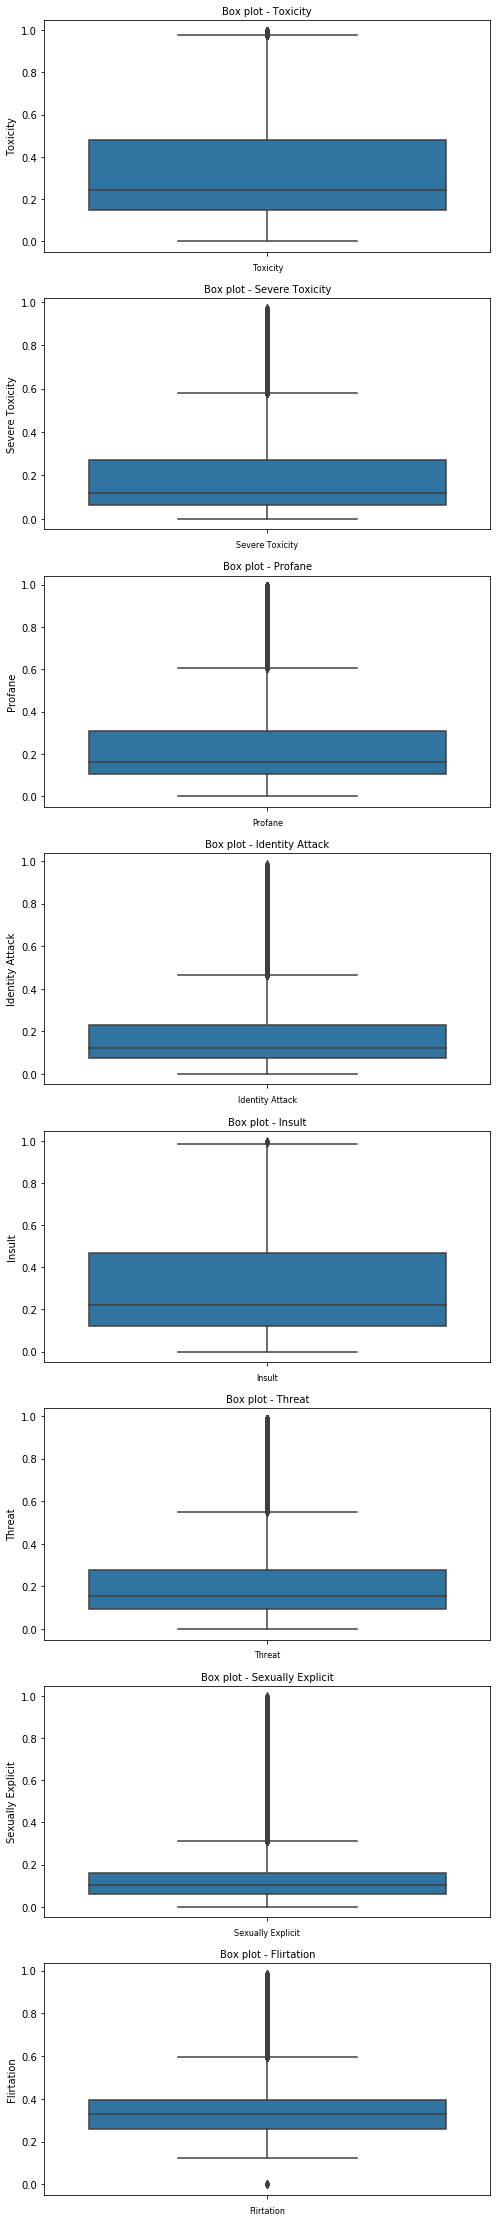

In [23]:
# box plots to examine toxicity scores
df3_features = df3.select("Toxicity","Severe Toxicity", "Profane", "Identity Attack", "Insult", "Threat", "Sexually Explicit", "Flirtation").toPandas()
l = df3_features.columns.values
fig, ax = plt.subplots(len(l), figsize=(len(l),40))
for i, col_val in enumerate(l):
    sns.boxplot(y=df3_features[col_val], ax=ax[i])
    ax[i].set_title('Box plot - {}'.format(col_val), fontsize=10)
    ax[i].set_xlabel(col_val, fontsize=8)
plt.show()

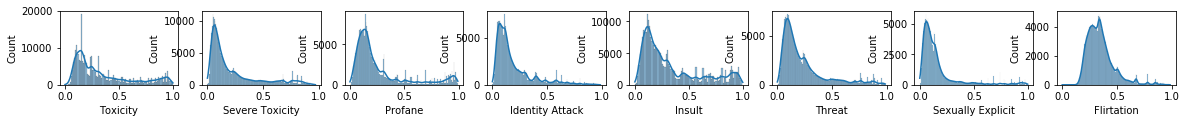

In [21]:
# distribution of toxic score values
# note: sns.histplot requires seaborn ver. 0.11+
number_of_columns = 8
number_of_rows =  1
plt.figure(figsize=(20,3))
for i in range(0,len(l)):
    plt.subplot(number_of_rows + 1,number_of_columns,i+1)
    sns.histplot(df3_features[l[i]],kde=True) 

In [31]:
# select variables to check correlation
df_features = df3.select("Toxicity","Severe Toxicity", "Profane", "Identity Attack", "Insult", "Threat", "Sexually Explicit", "Flirtation") 

# create RDD table for correlation calculation
rdd_table = df_features.rdd.map(lambda row: row[0:])

# get the correlation matrix
corr_mat=stat.corr(rdd_table, method="pearson")

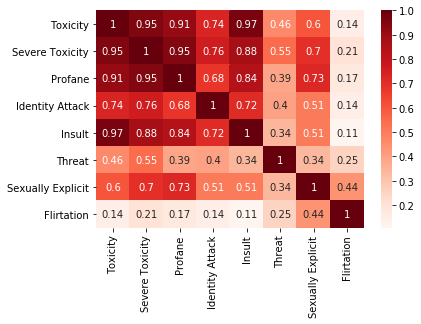

In [35]:
# correlation heatmap
sns.heatmap(corr_mat,cmap='Reds', annot=True,
        xticklabels=["Toxicity","Severe Toxicity", "Profane", "Identity Attack", "Insult", "Threat", "Sexually Explicit", "Flirtation"],
        yticklabels=["Toxicity","Severe Toxicity", "Profane", "Identity Attack", "Insult", "Threat", "Sexually Explicit", "Flirtation"])

In [27]:
# tweets counts based on tweet status category
tweetStatusCount = df3.groupBy("tweetstatus").count().orderBy(F.col("count").desc())

tweetStatusCount.show()

+--------------+------+
|   tweetstatus| count|
+--------------+------+
|      TWEET_OK|238272|
| TWEET_DELETED|  4133|
|USER_SUSPENDED|  2391|
|  USER_DELETED|  1401|
|USER_PROTECTED|  1087|
| TWEET_BLOCKED|   691|
+--------------+------+



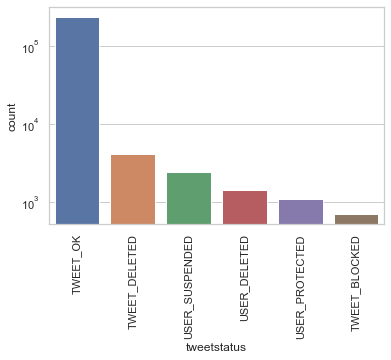

In [32]:
# bar plot of tweet status counts (log-scale)
sns.set_theme(style="whitegrid")
plt.xticks(rotation=90)
ax1 = sns.barplot(x="tweetstatus", y="count", data=tweetStatusCount.toPandas())
ax1.set_yscale("log")

In [35]:
statusToxicity = df3.groupBy("tweetstatus").agg(F.avg(F.col("Toxicity")).alias("avg_toxicity")).orderBy(F.col("avg_toxicity").desc()).toPandas()

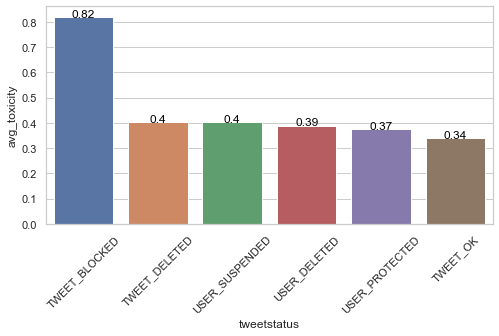

In [43]:
sns.set_theme(style="whitegrid")
plt.figure(figsize=(8,4))
plt.xticks(rotation=45)
ax2 = sns.barplot(x="tweetstatus", y="avg_toxicity", data=statusToxicity)
for index, row in statusToxicity.iterrows():
    ax2.text(row.name,row.avg_toxicity, round(row.avg_toxicity,2), color='black', ha="center")